# hw4

I'll be doing *Images, Numerics Exercise #1*.

> *Interpolation.* Create an image of a critically sampled Gaussian PSF centered at the middle
of a pixel. Create another image of the same PSF, but with its center offset some fraction
of a pixel from the first case. We will test how well different types of interpolation work by
trying to shift the first image using interpolation and comparing it to the second image.
> - (a) Use linear interpolation to try to shift the first image so the PSF has the same center
as in the second image. Compare the absolute and fractional differences (pixel-by-pixel)
between first image shifted and the second image.
> - (b) Perform the same test with sinc interpolation.
> - (c) Perform the same test with a “damped” version of sinc interpolation, which multiplies
the kernel by a broader sinc function; the Lanczos kernel.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import chic

## part (0): making the images

I believe 'critically-sampled' means 'sampled at the Nyquist rate'.

A Gaussian PSF is a two-dimensional Gaussian, which we'll take to be symmetric (i.e. $\sigma_x = \sigma_y = \sigma$, no covariance):
$$
\mathcal{G}(\vec{x}; \vec{\mu}, \sigma) = \frac{1}{2 \pi \sigma^2} \exp \left( - \frac{(\vec{x} - \vec{\mu})^2}{2 \sigma^2} \right)
$$

The Fourier transform of a Gaussian is a Gaussian, which has nonzero density as $\vec{k} \to \infty$, meaning that the maximum frequency is $\infty$ and the Nyquist rate is also $\infty$.

However, the *Images* notes state 

> The width of the PSF is usually characterized by its full-width half-maximum (FWHM). An
important property of an imaging system is its sampling density relative to the FWHM. If this
density is high enough, typically greater than 2 pixels per FWHM, the PSF will be close to Nyquist
sampled, meaning that if the image were noiseless it would preserve all of the information in
the image function.

Let's take this as definition: 'critically-sampled' means the sampling resolution is 2 pixels per FWHM.

For a one-dimensional normal distribution, the FWHM is $2 \sqrt{2 \ln 2} \; \sigma \approx 2.355 \sigma$ ([Wikipedia](https://en.wikipedia.org/wiki/Full_width_at_half_maximum#Normal_distribution)). For a 2D symmetric Gaussian, then, I expect it to be the same, since if we take $y = 0$, the behavior in $x$ is exactly the same (and vice versa).

Fixing our pixel size to just be 1 pixel (so we can use simply use arrays), we are choosing to set $\text{FWHM} = 2 \ \text{px}$. We can then solve for $\sigma = (2 \ln 2)^{-1/2} \approx 0.85$.

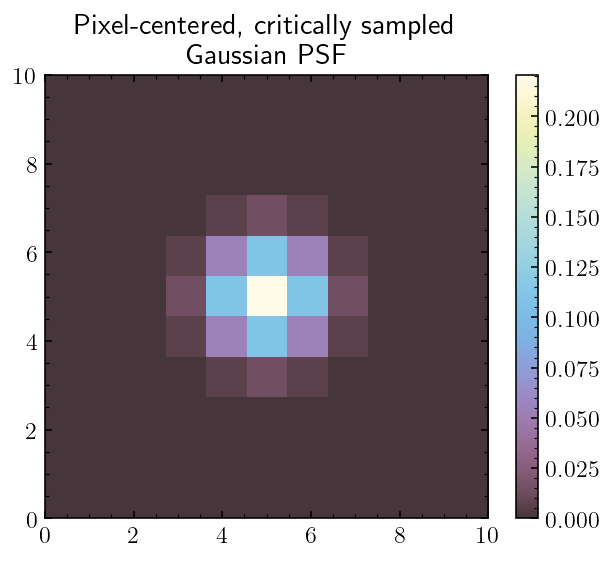

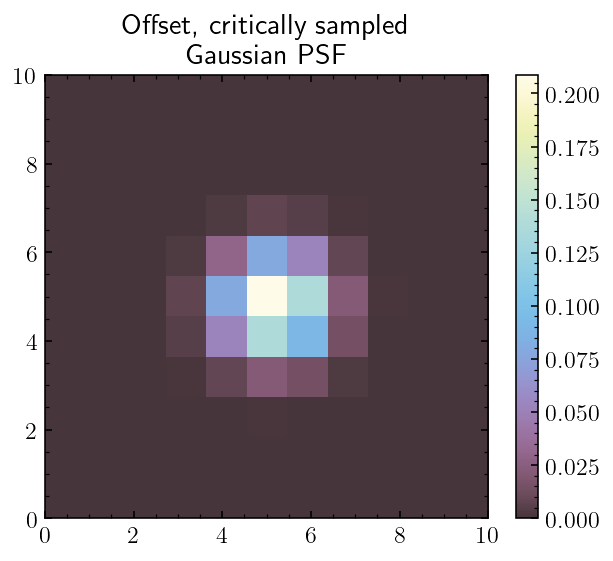

In [2]:
# let's make our critically sampled Gaussian image

def gaussian(x, mu, sigma):
    x = np.atleast_2d(x)
    mu = np.atleast_1d(mu)
    sigma = sigma
    delta_sq = np.square(x - mu).sum(-1)
    return np.exp( -0.5 * delta_sq / sigma**2 ) / (2 * np.pi * sigma**2)

# let's make a critically sampled one, i.e. one with sigma = 1/sqrt(2 ln 2)
sigma = 1. / np.sqrt(2 * np.log(2))

x, y = np.meshgrid(np.arange(11), np.arange(11))
X = np.stack((x, y), -1)

# first, we'll center it on the middle of a pixel
mu_1 = np.array([5, 5])
Z_1 = gaussian(X, mu_1, sigma)
plt.imshow(Z_1, origin='lower', extent=(x.min(), x.max(), y.min(), y.max()), vmin=0)
plt.title('Pixel-centered, critically sampled\nGaussian PSF')
plt.colorbar()
plt.show()

# next, we'll offset it from the pixel center by 0.2 px in each coordinate
mu_2 = np.array([5.2, 4.8])
Z_2 = gaussian(X, mu_2, sigma)
plt.imshow(Z_2, origin='lower', extent=(x.min(), x.max(), y.min(), y.max()), vmin=0)
plt.title('Offset, critically sampled\nGaussian PSF')
plt.colorbar()
plt.show()

## part (a): linear interpolation

We want to use linear interpolation to 're-center' the first image onto the second.

The first image has mean at $\mu_1 = (5, 5)$, where the second has mean $\mu_2 = (5.2, 4.8)$. This can equivalently be expressed in terms of a redefined coordinate system $x' = x - 0.2$, $y' = y + 0.2$, where now $\mu_1' = (5.2, 4.8)$. Hence, we can interpolate image 1 onto this new offset coordinate grid to obtain an estimate of image 2.

In [3]:
from scipy.interpolate import RegularGridInterpolator
from matplotlib.colors import CenteredNorm, SymLogNorm

First, we'll do this _with_ extrapolation.

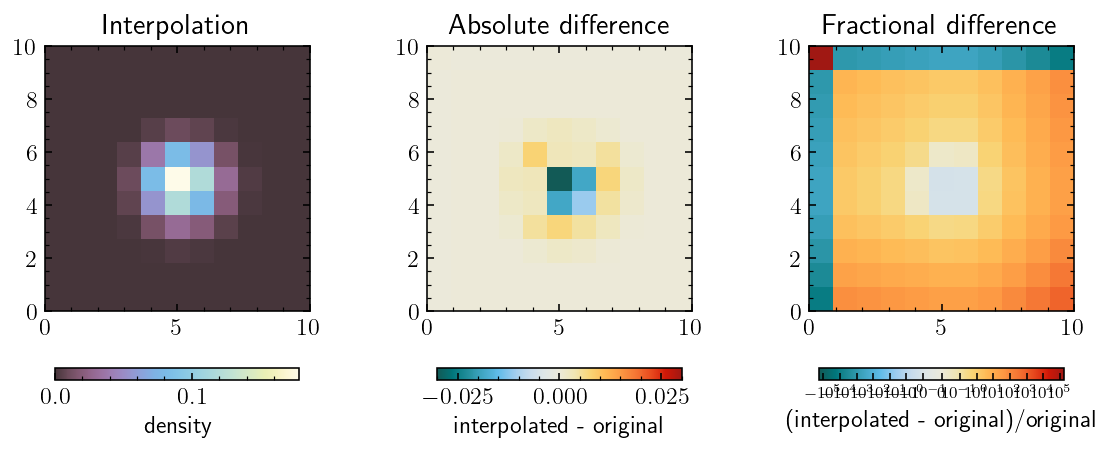

In [4]:
interp = RegularGridInterpolator((np.arange(11), np.arange(11)), Z_1, method='linear', bounds_error=False, fill_value=None)
new_X = X + np.array([-0.2, +0.2])
Z_3 = interp(new_X)
delta = Z_3 - Z_2
frac_delta = delta / Z_2
vlim = np.nanmax(np.abs(frac_delta))


fig, axs = plt.subplots(1, 3, figsize=(8, 3))

im = axs[0].imshow(Z_3, origin='lower', extent=(x.min(), x.max(), y.min(), y.max()), vmin=0)
cb = fig.colorbar(im, ax=axs[0], location='bottom', shrink=0.7)
cb.set_label('density')
axs[0].set_title('Interpolation')


im = axs[1].imshow(delta,
           origin='lower', extent=(x.min(), x.max(), y.min(), y.max()),
           cmap='tol_nightfall', norm=CenteredNorm())
cb = fig.colorbar(im, ax=axs[1], location='bottom', shrink=0.7)
cb.set_label('interpolated - original')
axs[1].set_title('Absolute difference')


im = axs[2].imshow(frac_delta,
           origin='lower', extent=(x.min(), x.max(), y.min(), y.max()),
           cmap='tol_nightfall',
           norm=SymLogNorm(1e-1, vmin=-vlim, vmax=+vlim))
cb = fig.colorbar(im, ax=axs[2], location='bottom', shrink=0.7)
cb.set_label('(interpolated - original)/original')
cb.ax.tick_params(labelsize=8)
axs[2].set_title('Fractional difference')

fig.tight_layout(pad=0.1)

plt.show()

Since the extrapolation dominates the fractional difference, let's also see this without extrapolation.

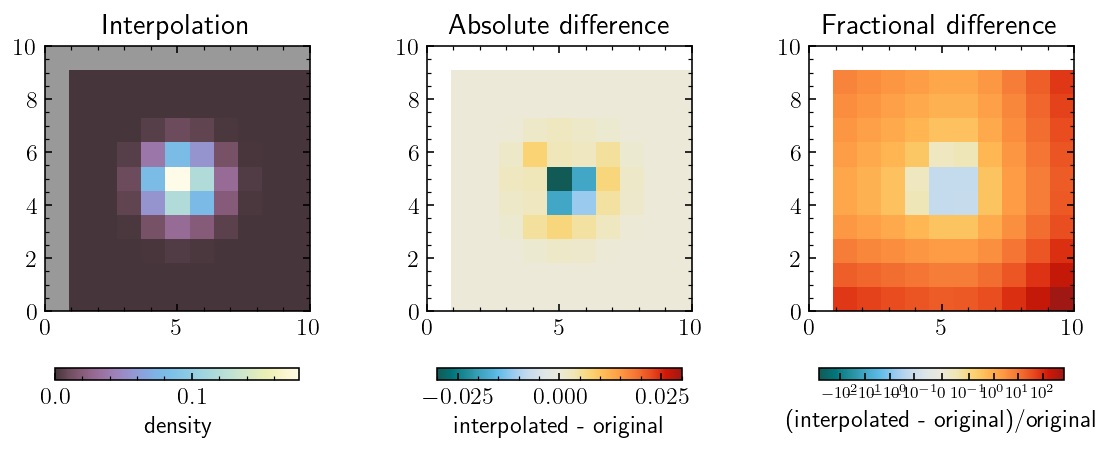

In [5]:
interp = RegularGridInterpolator((np.arange(11), np.arange(11)), Z_1, method='linear', bounds_error=False, fill_value=np.nan)
new_X = X + np.array([-0.2, +0.2])
_Z_3 = interp(new_X)
delta = _Z_3 - Z_2
frac_delta = delta / Z_2
vlim = np.nanmax(np.abs(frac_delta))


fig, axs = plt.subplots(1, 3, figsize=(8, 3))

im = axs[0].imshow(_Z_3, origin='lower', extent=(x.min(), x.max(), y.min(), y.max()), vmin=0)
cb = fig.colorbar(im, ax=axs[0], location='bottom', shrink=0.7)
cb.set_label('density')
axs[0].set_title('Interpolation')


im = axs[1].imshow(delta,
           origin='lower', extent=(x.min(), x.max(), y.min(), y.max()),
           cmap='tol_nightfall', norm=CenteredNorm())
cb = fig.colorbar(im, ax=axs[1], location='bottom', shrink=0.7)
cb.set_label('interpolated - original')
axs[1].set_title('Absolute difference')


im = axs[2].imshow(frac_delta,
           origin='lower', extent=(x.min(), x.max(), y.min(), y.max()),
           cmap='tol_nightfall',
           norm=SymLogNorm(1e-1, vmin=-vlim, vmax=+vlim))
cb = fig.colorbar(im, ax=axs[2], location='bottom', shrink=0.7)
cb.set_label('(interpolated - original)/original')
cb.ax.tick_params(labelsize=8)
axs[2].set_title('Fractional difference')

fig.tight_layout(pad=0.1)

plt.show()

In [6]:
np.count_nonzero(np.abs(frac_delta) > 1e-1) / np.prod([frac_delta.shape])

0.7933884297520661

So, even though the interpolated image looks good by eye, it appears that it picks up errors of greater than 10% in almost 80% of the pixels.

## part (b): sinc interpolation

According to [Wikipedia](https://en.wikipedia.org/wiki/Whittaker%E2%80%93Shannon_interpolation_formula), one-dimensional sinc interpolation is given by
$$
x(t) = \sum_{n = -\infty}^{\infty} x[n] \; \text{sinc} \left(\frac{t - nT}{T}\right),
$$
where $\text{sinc}(t) = \sin \pi t/\pi t$, $x(t)$ is the interpolated value, $x[n]$ is a sample point, and $T$ is a parameter which sets the bandlimit $1/2T$. For our purposes, we should take $T$ to be the sampling resolution, which is $1 \ \text{px}$. We also take $x$ and $y$ to be independent for our PSF, so the $\text{sinc}$ kernels in each dimension just multiply. Thus, our interpolation looks like
$$
Z_\text{interp}(x, y) = \sum_{n_x,n_y} Z[x,y] \; \text{sinc} \left(x - n_x\right) \; \text{sinc} \left(y - n_y\right),
$$

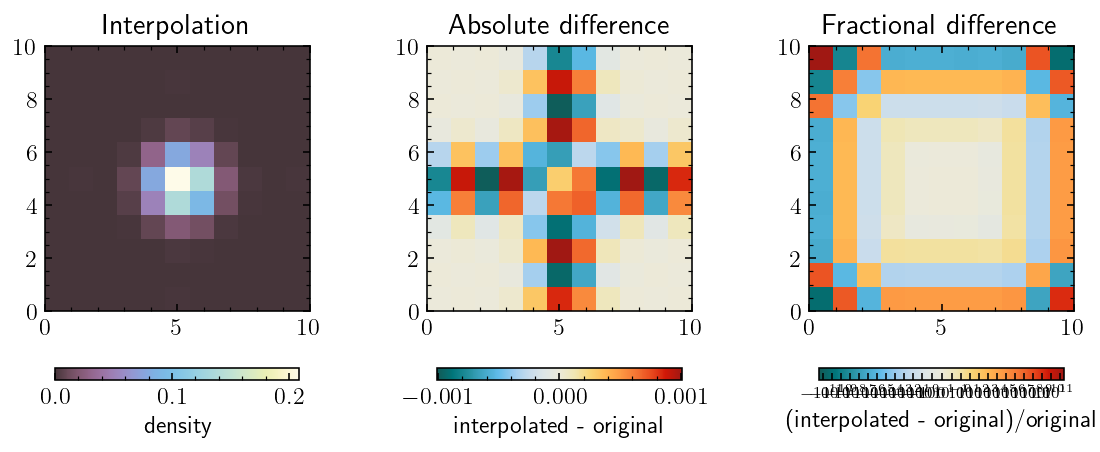

In [7]:
Z_4 = (Z_1[None, None, :, :] * np.prod(np.sinc(new_X[:,:,None,None,:] - X[None,None,:,:,:]), axis=-1)).sum(-1).sum(-1)
delta = Z_4 - Z_2
frac_delta = delta / Z_2
vlim = np.nanmax(np.abs(frac_delta))


fig, axs = plt.subplots(1, 3, figsize=(8, 3))

im = axs[0].imshow(Z_4, origin='lower', extent=(x.min(), x.max(), y.min(), y.max()), vmin=0)
cb = fig.colorbar(im, ax=axs[0], location='bottom', shrink=0.7)
cb.set_label('density')
axs[0].set_title('Interpolation')


im = axs[1].imshow(delta,
           origin='lower', extent=(x.min(), x.max(), y.min(), y.max()),
           cmap='tol_nightfall', norm=CenteredNorm())
cb = fig.colorbar(im, ax=axs[1], location='bottom', shrink=0.7)
cb.set_label('interpolated - original')
axs[1].set_title('Absolute difference')


im = axs[2].imshow(frac_delta,
           origin='lower', extent=(x.min(), x.max(), y.min(), y.max()),
           cmap='tol_nightfall',
           norm=SymLogNorm(1e-1, vmin=-vlim, vmax=+vlim))
cb = fig.colorbar(im, ax=axs[2], location='bottom', shrink=0.7)
cb.set_label('(interpolated - original)/original')
cb.ax.tick_params(labelsize=8)
axs[2].set_title('Fractional difference')

fig.tight_layout(pad=0.1)

plt.show()

Again the interpolation looks great by eye, but now it looks like we get some _crazy_ fractional errors.

## part (c): Lanczos interpolation

The Lanczos kernel is given by
$$
L(x; a) = \mathbb{1}(|x| < a) \;\text{sinc}(x) \;\text{sinc}(x/a),
$$
where $\mathbb{1}(\text{cond})$ is one when $\text{cond}$ is true and zero otherwise, and $a$ is a parameter defining the size of the kernel. We'll try taking $a = 2$, $3$, and $4$.

Again, in 2D, the filters in each coordinate just multiply, so our interpolation looks like this:
$$
Z_\text{interp}(x, y) = \sum_{n_x,n_y} Z[x,y] \; L \left(x - n_x; a\right) \; L \left(y - n_y; a\right),
$$

First, with $a = 2$:

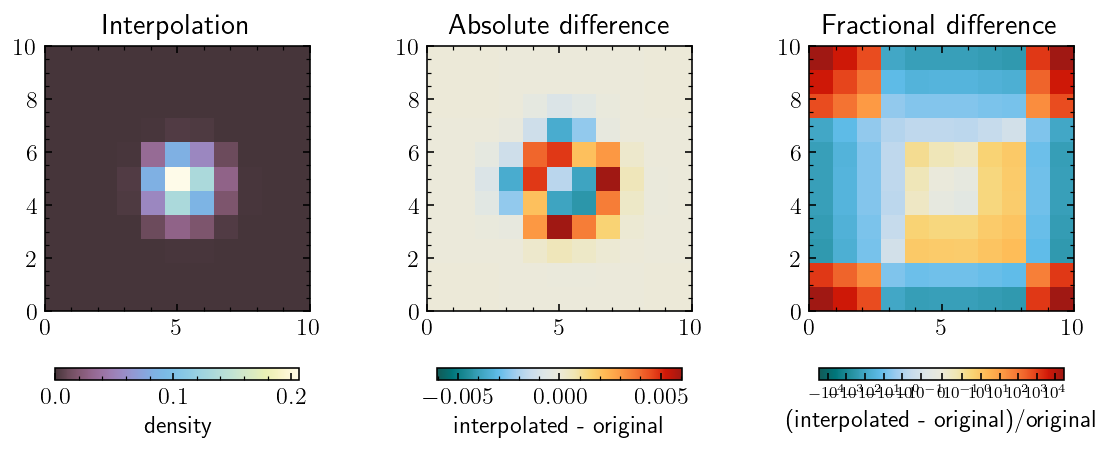

In [8]:
def lanczos(x, a=2):
    return (np.abs(x) < a).astype(float) * np.sinc(x) * np.sinc(x / a)

Z_5 = (Z_1[None, None, :, :] * np.prod(lanczos(new_X[:,:,None,None,:] - X[None,None,:,:,:]), axis=-1)).sum(-1).sum(-1)
delta = Z_5 - Z_2
frac_delta = delta / Z_2
vlim = np.nanmax(np.abs(frac_delta))


fig, axs = plt.subplots(1, 3, figsize=(8, 3))

im = axs[0].imshow(Z_5, origin='lower', extent=(x.min(), x.max(), y.min(), y.max()), vmin=0)
cb = fig.colorbar(im, ax=axs[0], location='bottom', shrink=0.7)
cb.set_label('density')
axs[0].set_title('Interpolation')


im = axs[1].imshow(delta,
           origin='lower', extent=(x.min(), x.max(), y.min(), y.max()),
           cmap='tol_nightfall', norm=CenteredNorm())
cb = fig.colorbar(im, ax=axs[1], location='bottom', shrink=0.7)
cb.set_label('interpolated - original')
axs[1].set_title('Absolute difference')


im = axs[2].imshow(frac_delta,
           origin='lower', extent=(x.min(), x.max(), y.min(), y.max()),
           cmap='tol_nightfall',
           norm=SymLogNorm(1e-1, vmin=-vlim, vmax=+vlim))
cb = fig.colorbar(im, ax=axs[2], location='bottom', shrink=0.7)
cb.set_label('(interpolated - original)/original')
cb.ax.tick_params(labelsize=8)
axs[2].set_title('Fractional difference')

fig.tight_layout(pad=0.1)

plt.show()

Next with $a = 3$:

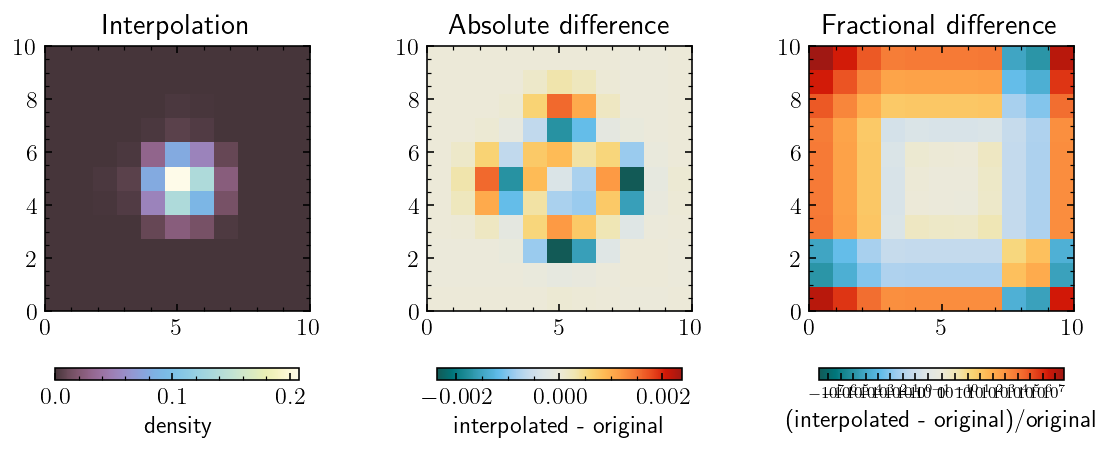

In [9]:
def lanczos(x, a=3):
    return (np.abs(x) < a).astype(float) * np.sinc(x) * np.sinc(x / a)

Z_6 = (Z_1[None, None, :, :] * np.prod(lanczos(new_X[:,:,None,None,:] - X[None,None,:,:,:]), axis=-1)).sum(-1).sum(-1)
delta = Z_6 - Z_2
frac_delta = delta / Z_2
vlim = np.nanmax(np.abs(frac_delta))


fig, axs = plt.subplots(1, 3, figsize=(8, 3))

im = axs[0].imshow(Z_6, origin='lower', extent=(x.min(), x.max(), y.min(), y.max()), vmin=0)
cb = fig.colorbar(im, ax=axs[0], location='bottom', shrink=0.7)
cb.set_label('density')
axs[0].set_title('Interpolation')


im = axs[1].imshow(delta,
           origin='lower', extent=(x.min(), x.max(), y.min(), y.max()),
           cmap='tol_nightfall', norm=CenteredNorm())
cb = fig.colorbar(im, ax=axs[1], location='bottom', shrink=0.7)
cb.set_label('interpolated - original')
axs[1].set_title('Absolute difference')


im = axs[2].imshow(frac_delta,
           origin='lower', extent=(x.min(), x.max(), y.min(), y.max()),
           cmap='tol_nightfall',
           norm=SymLogNorm(1e-1, vmin=-vlim, vmax=+vlim))
cb = fig.colorbar(im, ax=axs[2], location='bottom', shrink=0.7)
cb.set_label('(interpolated - original)/original')
cb.ax.tick_params(labelsize=8)
axs[2].set_title('Fractional difference')

fig.tight_layout(pad=0.1)

plt.show()

Finally with $a = 4$:

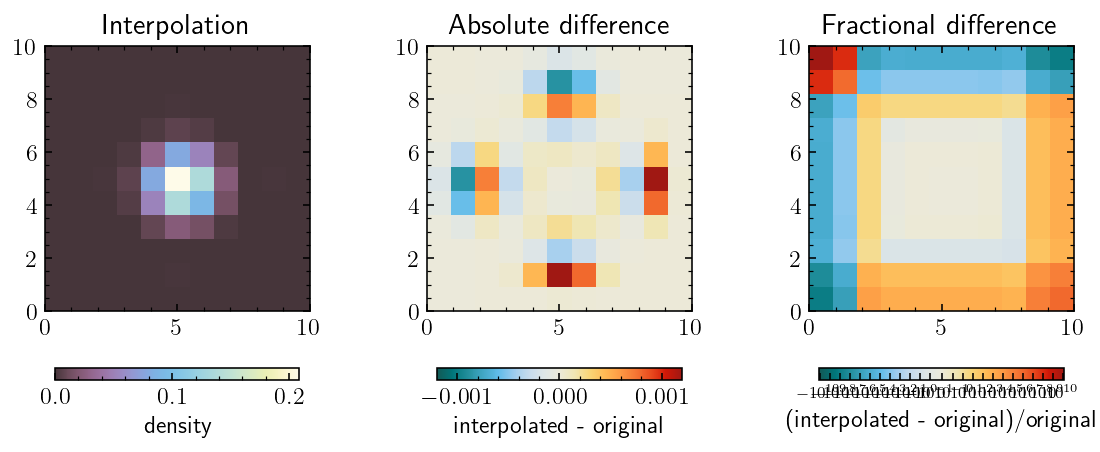

In [10]:
def lanczos(x, a=4):
    return (np.abs(x) < a).astype(float) * np.sinc(x) * np.sinc(x / a)

Z_7 = (Z_1[None, None, :, :] * np.prod(lanczos(new_X[:,:,None,None,:] - X[None,None,:,:,:]), axis=-1)).sum(-1).sum(-1)
delta = Z_7 - Z_2
frac_delta = delta / Z_2
vlim = np.nanmax(np.abs(frac_delta))


fig, axs = plt.subplots(1, 3, figsize=(8, 3))

im = axs[0].imshow(Z_7, origin='lower', extent=(x.min(), x.max(), y.min(), y.max()), vmin=0)
cb = fig.colorbar(im, ax=axs[0], location='bottom', shrink=0.7)
cb.set_label('density')
axs[0].set_title('Interpolation')


im = axs[1].imshow(delta,
           origin='lower', extent=(x.min(), x.max(), y.min(), y.max()),
           cmap='tol_nightfall', norm=CenteredNorm())
cb = fig.colorbar(im, ax=axs[1], location='bottom', shrink=0.7)
cb.set_label('interpolated - original')
axs[1].set_title('Absolute difference')


im = axs[2].imshow(frac_delta,
           origin='lower', extent=(x.min(), x.max(), y.min(), y.max()),
           cmap='tol_nightfall',
           norm=SymLogNorm(1e-1, vmin=-vlim, vmax=+vlim))
cb = fig.colorbar(im, ax=axs[2], location='bottom', shrink=0.7)
cb.set_label('(interpolated - original)/original')
cb.ax.tick_params(labelsize=8)
axs[2].set_title('Fractional difference')

fig.tight_layout(pad=0.1)

plt.show()

The fractional errors on these are kind of huge. Again, though, the interpolated image looks like a great match by eye, and the absolute differences are fairly good everywhere.

## comparison

absolute errors:

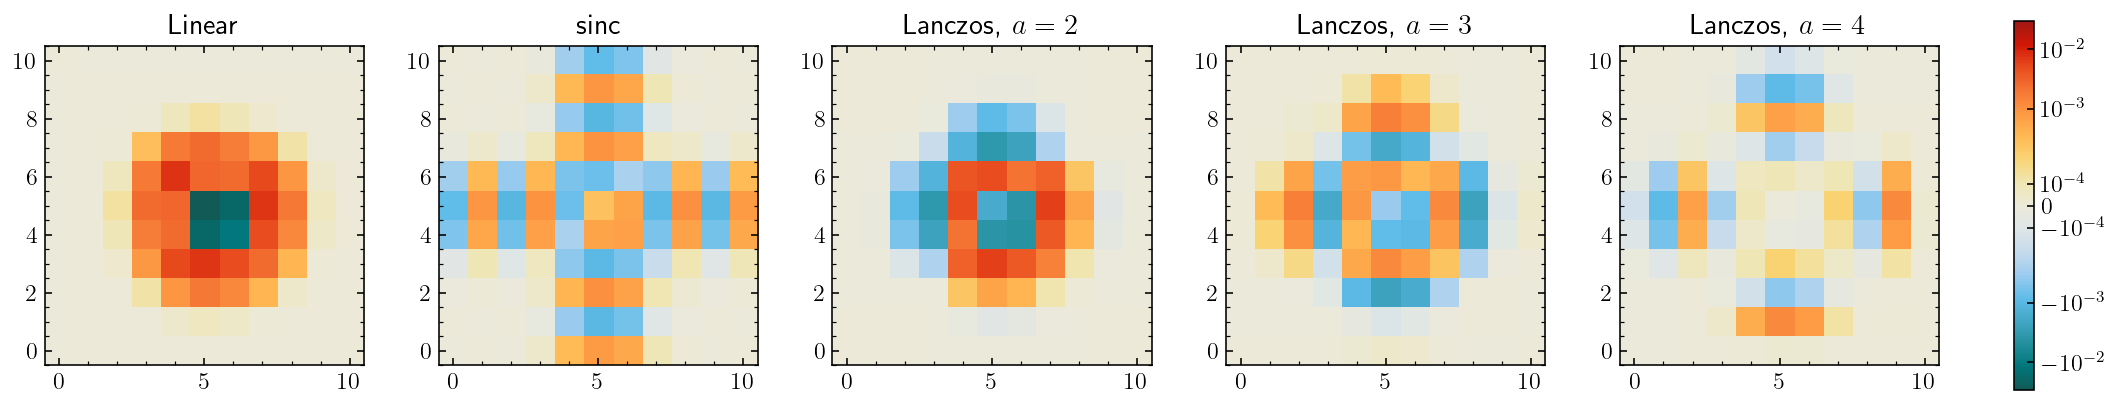

In [11]:
fig, axs = plt.subplots(1, 6, figsize=(15, 3), gridspec_kw=dict(width_ratios=[8, 8, 8, 8, 8, 0.5]))

vlim = 0
for _Z in [Z_3, Z_4, Z_5, Z_6, Z_7]:
    vlim = max( vlim, np.abs(_Z - Z_2).max() )

norm = SymLogNorm(vlim / 1e2, vmin=-vlim, vmax=+vlim)

for i, _Z in enumerate([Z_3, Z_4, Z_5, Z_6, Z_7]):
    im = axs[i].imshow(_Z - Z_2, origin='lower', norm=norm, cmap='tol_nightfall')

fig.colorbar(im, cax=axs[-1])

axs[0].set_title('Linear')
axs[1].set_title('sinc')
axs[2].set_title('Lanczos, $a=2$')
axs[3].set_title('Lanczos, $a=3$')
axs[4].set_title('Lanczos, $a=4$')

fig.tight_layout()
plt.show()

fractional errors:

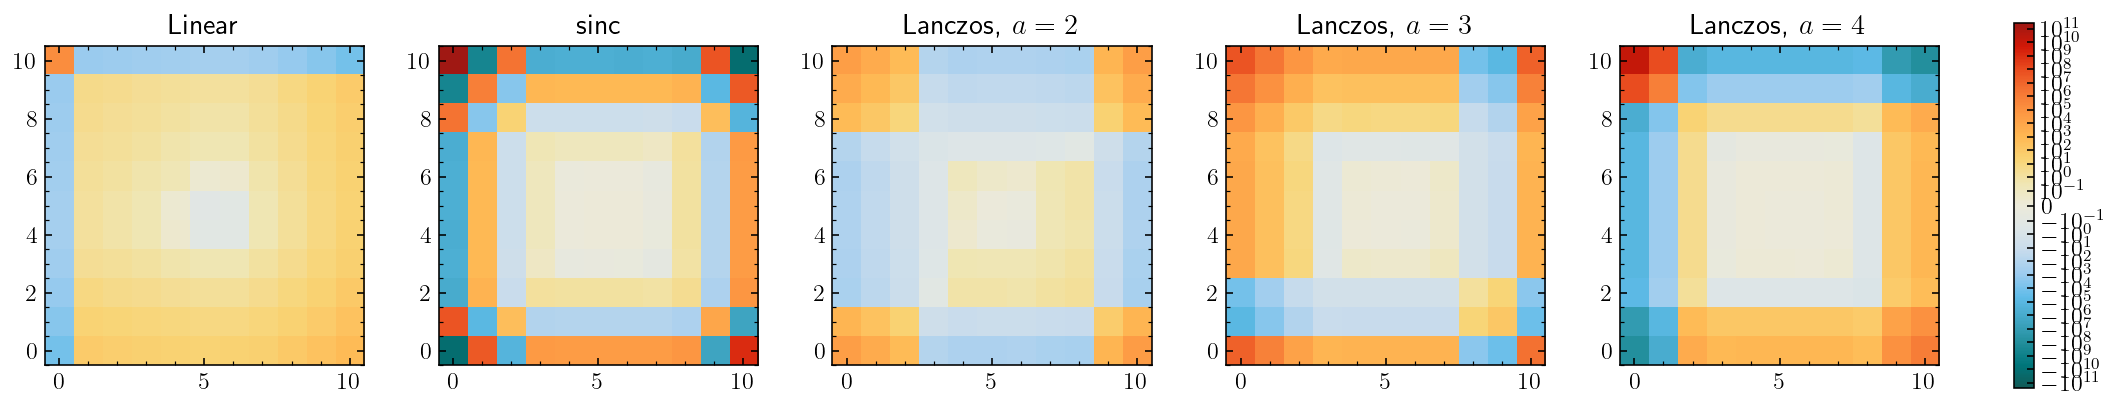

In [12]:
fig, axs = plt.subplots(1, 6, figsize=(15, 3), gridspec_kw=dict(width_ratios=[8, 8, 8, 8, 8, 0.5]))

vlim = 0
for _Z in [Z_3, Z_4, Z_5, Z_6, Z_7]:
    vlim = max( vlim, np.abs((_Z - Z_2)/Z_2).max() )

norm = SymLogNorm(1e-1, vmin=-vlim, vmax=+vlim)

for i, _Z in enumerate([Z_3, Z_4, Z_5, Z_6, Z_7]):
    im = axs[i].imshow((_Z - Z_2)/Z_2, origin='lower', norm=norm, cmap='tol_nightfall')

fig.colorbar(im, cax=axs[-1])

axs[0].set_title('Linear')
axs[1].set_title('sinc')
axs[2].set_title('Lanczos, $a=2$')
axs[3].set_title('Lanczos, $a=3$')
axs[4].set_title('Lanczos, $a=4$')

fig.tight_layout()
plt.show()

While linear interpolation has the worst performance (by absolute error) in the center of the image, it actually seems to perform the best for the wings of the PSF (by fractional error). By contrast, the Lanczos kernels seem to have the best performance in the center of the image, with improving error as $a$ increases, but they get progressively worse in the corners as $a$ increases.